# Andvaranaut tutorial

In [1]:
# Load all modules from andvaranaut package
from andvaranaut import *

In [2]:
# Magic features for development purposes
%load_ext autoreload
%autoreload 2

## LHC Module

User supplies target function, which takes a 1D numpy array of nx inputs and returns a 1D numpy array of ny outputs. They must also supply a list of univariate distributions from scipy stats for each of the nx inputs.

In [3]:
# Example target function (2 inputs, 2 outputs)
# A more complex target function will produce an input file, 
# execute external code, and perform post-processing on output
def test_fun(x):
  x1,x2 = x
  return np.array([x1**2-x1-x2**2*x1+x2])

# Input variable probability distributions
import scipy.stats as st
sample_space = [st.uniform(loc=0,scale=2),\
                st.uniform(loc=1,scale=0.5)]

In [4]:
# Latin hypercube class instance, with correct arguments
l = LHC(nx=2,ny=1,priors=sample_space,target=test_fun,\
       parallel=False,nproc=1,verbose=True)

Sampling makes use of the latin_random function from py-design

In [5]:
# Sample input distributions by LHC and evaluate target function
l.sample(nsamps=4)
print(l.x)
print(l.y)

Evaluating 4 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.00 s
[[0.74951094 1.02107122]
 [0.03035373 1.39392901]
 [1.65511819 1.26495478]
 [1.07146334 1.2200149 ]]
[[ 0.05189699]
 [ 1.30551818]
 [-0.29911934]
 [-0.29821973]]


Parallel execution makes use of the ray package. This also works with SLURM submission if a SLURM script calls a python script with these commands in. (Tutorial will be added at a later date)

In [6]:
# Can also execute target function evaluation in parallel
l.parallel = True
l.nproc = 4
l.sample(nsamps=4)
ray.shutdown() # Shutdown ray parallelism, this command only good for interactive sessions
l.parallel = False
print(l.x)
print(l.y)

Evaluating 4 latin hypercube samples...


2024-02-23 12:18:22,070	INFO worker.py:1724 -- Started a local Ray instance.


Run is 100.0% complete.
Time taken: 3.37 s
[[0.74951094 1.02107122]
 [0.03035373 1.39392901]
 [1.65511819 1.26495478]
 [1.07146334 1.2200149 ]
 [0.41701078 1.46789161]
 [1.20010767 1.35433589]
 [0.70962562 1.19826551]
 [1.67783492 1.12334937]]
[[ 0.05189699]
 [ 1.30551818]
 [-0.29911934]
 [-0.29821973]
 [ 0.32624329]
 [-0.60678169]
 [-0.0267006 ]
 [ 0.14336142]]


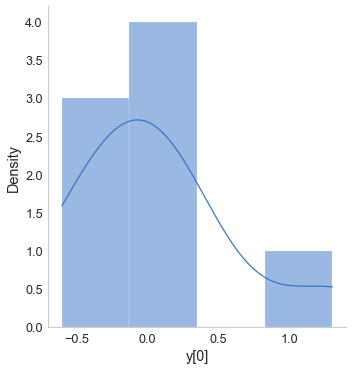

In [7]:
# Plot output distributions based on kernel density estimation
l.y_dist()

In [8]:
# Optionally delete n samples
# Default is deletion by closest sample to a coarse LHC of number of samples for deletion
l.del_samples(ndels=2,method='coarse_lhc')
print(l.x)
print(l.y,'\n')
# Can also delete by random indexing
l.del_samples(ndels=2,method='random')
print(l.x)
print(l.y,'\n')
# or by specific data indexes
l.del_samples(method='specific',idx=[0,1])
print(l.x)
print(l.y,'\n')

[[0.74951094 1.02107122]
 [0.03035373 1.39392901]
 [1.65511819 1.26495478]
 [1.07146334 1.2200149 ]
 [0.70962562 1.19826551]
 [1.67783492 1.12334937]]
[[ 0.05189699]
 [ 1.30551818]
 [-0.29911934]
 [-0.29821973]
 [-0.0267006 ]
 [ 0.14336142]] 

[[0.03035373 1.39392901]
 [1.65511819 1.26495478]
 [1.67783492 1.12334937]
 [1.07146334 1.2200149 ]]
[[ 1.30551818]
 [-0.29911934]
 [ 0.14336142]
 [-0.29821973]] 

[[1.67783492 1.12334937]
 [1.07146334 1.2200149 ]]
[[ 0.14336142]
 [-0.29821973]] 



If datasets exist then it is possible to set the class attributes directly with these. They must be in the form of 2d numpy float arrays. An additional consideration is the provided x data must be compatible with the existing distributions. WARNING: This will likely invalidate relationship of samples to selected input distributions and therefore invalidate output distributions.

In [9]:
x = np.random.rand(5,2)
x[:,1] = x[:,1]/2 + 1
y = np.random.rand(5,1)
l.set_data(x=x,y=y)
print(l.x)
print(l.y)

[[0.71443753 1.21199874]
 [0.01940172 1.06322048]
 [0.44794714 1.07826833]
 [0.14248921 1.09023519]
 [0.50618581 1.45270137]]
[[0.34243555]
 [0.35032225]
 [0.19799237]
 [0.65537781]
 [0.22686555]]


## GP Module

In addition to the arguments provided to the lhc class, there are additional arguments for a list of classes which handle conversion and reversion of the x and y datasets, respectively. These are necessary for optimising surrogate performance, and usually consist of transforming bounded ranges on inputs and outputs to unbounded. Normalisations to get numbers O(1) are also useful and can be implemented either here or within the target function.

These conversion/reversion arguments are optional, and can be left blank if desired. Standard methods are provided in andvaranaut.transform. A user can define their own conversion classes in this module.

In [10]:
# Define lists of conversion/reversion class instances for each x and y variable
xconrevs = [uniform(sample_space[0]),normal(sample_space[1])]
yconrevs = [None]
# Instance of gp, only nx, ny, dists, and target are req
g = GPMCMC(kernel='RBF',noise=False,xconrevs=xconrevs,yconrevs=yconrevs,\
       nx=2,ny=1,priors=sample_space,target=test_fun,parallel=False,nproc=4,verbose=True)


Time taken: 0.00 s


Methods from lhc class are inherited by the GP class with some additions like automatic conversion of new samples

In [11]:
g.sample(2)
print(g.x)
print(g.y)
print(g.xc)
print(g.yc)
print(g.ym)

Evaluating 2 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.00 s
Run is 100.0% complete.
Time taken: 0.00 s
[[1.66839574 1.08829025]
 [0.72727751 1.39424885]]
[[ 0.22743154]
 [-0.21787256]]
[[ 0.83419787 -1.12035801]
 [ 0.36363876  0.99938538]]
[[ 0.22743154]
 [-0.21787256]]
[[0.]
 [0.]]


Can change conversion/reversion classes without reinitialising class

In [12]:
xconrevs = [maxmin(g.x[:,0]),maxmin(g.x[:,1])]
yconrevs = [meanstd(g.y[:,0])]
g.change_conrevs(xconrevs,yconrevs)
print(g.x)
print(g.y)
print(g.xc)
print(g.yc)
print(g.ym)

[[1.66839574 1.08829025]
 [0.72727751 1.39424885]]
[[ 0.22743154]
 [-0.21787256]]
[[0.99 0.01]
 [0.01 0.99]]
[[ 1.]
 [-1.]]
[[0.]
 [0.]]


Take some more samples and fit GP surrogate to converted data

In [13]:
g.sample(nsamps=98)
print(len(g.ym),len(g.y))

Evaluating 98 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.00 s
Run is 100.0% complete.
Time taken: 0.00 s
100 100


In [14]:
g.fit(restarts=1)

Your fitted model will be a PyMC object and as such will retain all PyMC functionality. It can be accessed as the 'm' attribute of the gp class.

The fitted hyperparameters are stored as g.hypers

In [15]:
print(g.hypers)

{'l_log__': array([0.93165542, 1.46555689]), 'kv_log__': array([6.03175742]), 'l': array([2.53870832, 4.32995388]), 'kv': array([416.44625569])}


Make a train-test set and produce plots to assess GP performance

In [16]:
g.train_test(training_frac=0.9)

{'l_log__': array([0.93165542, 1.46555689]), 'kv_log__': array([6.03175742]), 'l': array([2.53870832, 4.32995388]), 'kv': array([416.44625569])}
Predicting...
Time taken: 0.65 s
RMSE for y is: 2.76693e-04
Mean absoulte error for y is: 1.46029e-04
Mean percentage error for y is: 0.02830%
R^2 for y is: 1.00000


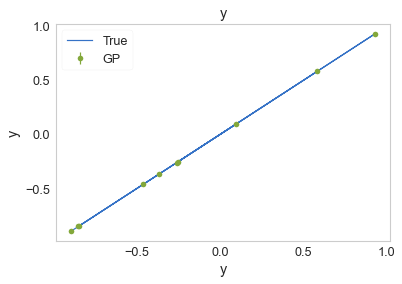

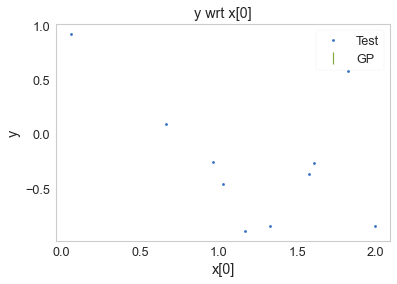

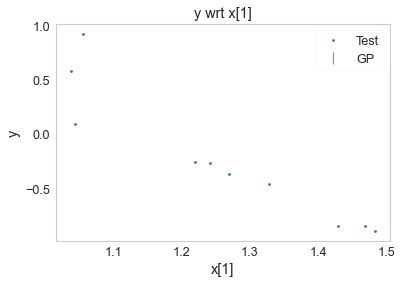

In [17]:
g.test_plots(revert=True,yplots=True,xplots=True)

Can change model details (kernel choice and whether data contains noise) without reinitialsing class. This will scrub any fitted model and require a new call to gp.fit().


{'gv_log__': array(-30.69039598), 'l_log__': array([1.77744861, 2.47418969]), 'kv_log__': array([5.85962575]), 'gv': array(4.69170157e-14), 'l': array([ 5.91474635, 11.87208309]), 'kv': array([350.5929107])}
Predicting...
Time taken: 0.36 s
RMSE for y is: 1.38244e-03
Mean absoulte error for y is: 4.95699e-04
Mean percentage error for y is: 0.06217%
R^2 for y is: 0.99999


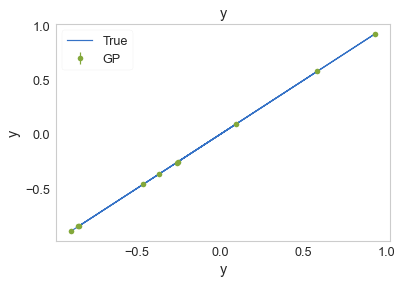

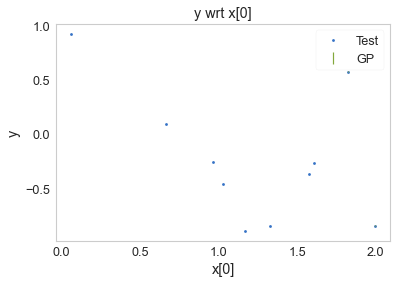

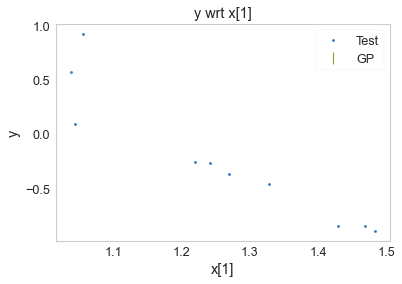

In [18]:
g.change_model(kernel='Matern52',noise=True)
g.test_plots(method='map')

Propagate uncertainty using surrogate and get target distributions


Predicting...
Time taken: 0.91 s


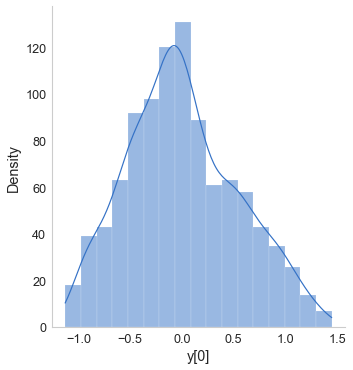

In [19]:
g.fit()
x,y = g.y_dist(mode='hist_kde',nsamps=1000,return_data=True,surrogate=True)

Plot also the distrutions based on underyling 100 LHC samples

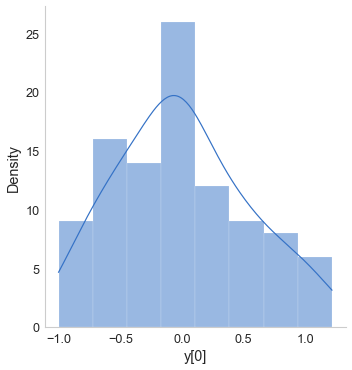

In [20]:
g.y_dist(surrogate=False)

Get 1000 actual function evaluations for comparison with GP surrogate plots. GP based on 100 evaluations gives good qualitative agreement.

In [21]:
l = LHC(nx=2,ny=1,priors=sample_space,target=test_fun,verbose=True)

In [22]:
l.sample(1000)

Evaluating 1000 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.02 s


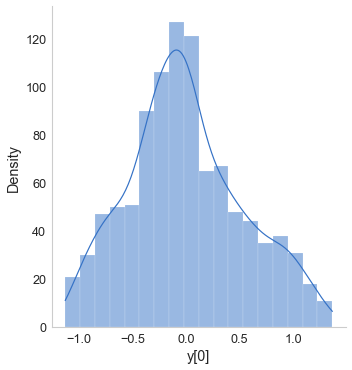

In [23]:
l.y_dist()

The lengthscales of the fitted GP give an insight into sensitivities of the outputs to the inputs.

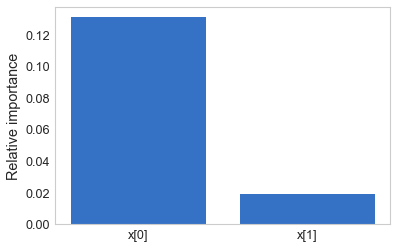

In [24]:
g.relative_importances()

## Bayesian Optimisation

In [26]:
g.BO(opt_type='max',max_iter=2)
print(g.xopt,g.yopt)

Running Bayesian minimisation...
Current optima is 1.2180871013330516 at x point [0.00689554 1.23546018]
Iteration 0
Predicting...
Time taken: 1.01 s


/home/u1997128/Documents/PhD/andvaranaut/andvaranaut/gpmcmc.py:566: RuntimeWarning: divide by zero encountered in divide
  yv /= np.power(y,2)
/home/u1997128/.local/lib/python3.10/site-packages/pymc/model/core.py:1100: UserWarning: Model.initial_values is deprecated. Use Model.rvs_to_initial_values instead.
  warnings.warn(


Function opt is -0.274
Refining [4.61801456e-04 1.49982761e+00]



{'x0': -13.55, 'x1': -11.43, 'pot': 0.28}
Predicting...
Time taken: 0.67 s
Predicted [[1.49371272]] at x point [[2.62119593e-06 1.49999456e+00]]
Run is 100.0% complete.
Time taken: 0.00 s
Run is 100.0% complete.
Time taken: 0.00 s
New sample is [[1.49998604]] at x point [[2.62119593e-06 1.49999456e+00]]



Iteration 1
Predicting...
Time taken: 0.99 s


/home/u1997128/Documents/PhD/andvaranaut/andvaranaut/gpmcmc.py:566: RuntimeWarning: divide by zero encountered in divide
  yv /= np.power(y,2)
/home/u1997128/.local/lib/python3.10/site-packages/pymc/model/core.py:1100: UserWarning: Model.initial_values is deprecated. Use Model.rvs_to_initial_values instead.
  warnings.warn(


Function opt is -0.000
Refining [1.47207395 1.05643482]



{'x0': -1.64, 'x1': -2.3, 'pot': 0.0}
Relative convergence in sample: 280801.6151800584
Predicting...
Time taken: 0.36 s
Predicted [[0.10843317]] at x point [[1.47207395 1.05643482]]
Run is 100.0% complete.
Time taken: 0.00 s
Run is 100.0% complete.
Time taken: 0.00 s
New sample is [[0.10844778]] at x point [[1.47207395 1.05643482]]



[2.62119593e-06 1.49999456e+00] 1.499986037405541


In [27]:
g.BO(opt_type='min',max_iter=2)
print(g.xopt,g.yopt)

Running Bayesian minimisation...
Current optima is -1.001555524044409 at x point [1.25567484 1.49903522]
Iteration 0
Predicting...
Time taken: 0.87 s


/home/u1997128/Documents/PhD/andvaranaut/andvaranaut/gpmcmc.py:566: RuntimeWarning: divide by zero encountered in divide
  yv /= np.power(y,2)
/home/u1997128/.local/lib/python3.10/site-packages/pymc/model/core.py:1100: UserWarning: Model.initial_values is deprecated. Use Model.rvs_to_initial_values instead.
  warnings.warn(


Function opt is -0.137
Refining [1.6288976  1.49952936]



{'x0': -1.88, 'x1': -13.43, 'pot': 0.14}
Predicting...
Time taken: 0.37 s
Predicted [[-1.13998694]] at x point [[1.62411251 1.49999927]]
Run is 100.0% complete.
Time taken: 0.00 s
Run is 100.0% complete.
Time taken: 0.00 s
New sample is [[-1.14062137]] at x point [[1.62411251 1.49999927]]



Iteration 1
Predicting...
Time taken: 1.82 s


/home/u1997128/Documents/PhD/andvaranaut/andvaranaut/gpmcmc.py:566: RuntimeWarning: divide by zero encountered in divide
  yv /= np.power(y,2)
/home/u1997128/.local/lib/python3.10/site-packages/pymc/model/core.py:1100: UserWarning: Model.initial_values is deprecated. Use Model.rvs_to_initial_values instead.
  warnings.warn(


Function opt is -0.000
Refining [1.60614973 1.49994221]



{'x0': -1.88, 'x1': -15.48, 'pot': 0.0}
Convergence at relative tolerance 0.00012496901739491144 achieved with point [[1.62451774 1.4999999 ]]
[1.62411251 1.49999927] -1.140621372639337


## Utils

### Save and load objects

In [28]:
# Save lhc class including datasets
l = LHC(nx=2,ny=1,priors=sample_space,target=test_fun)
l.sample(2)
print(l.x)
print(l.y)
save_object(obj=l,fname='lhc_tut.pickle')

[[0.13425758 1.03465561]
 [1.46713504 1.45683726]]
[[ 0.77469875]
 [-0.97162298]]


In [29]:
# Load lhc class
l = load_object(fname='lhc_tut.pickle')
print(l.x)
print(l.y)

[[0.13425758 1.03465561]
 [1.46713504 1.45683726]]
[[ 0.77469875]
 [-0.97162298]]
